In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import *
from AnalyseDefects import AnalyseDefects
from AnalyseDefectsAll import AnalyseDefectsAll

In [2]:
def gen_analysis_dict(LL, mode):

    dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05', \
              suffix = "short", priority = -1, LX = LL, Nframes = 181)
    dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_long', \
                suffix = "long", priority = 0, LX = LL, Nframes = 400)
    dvery_long = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long',\
                    suffix = "very_long", priority = 3, LX = LL, Nframes = 1500)
    dvery_long2 = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long_v2',\
                    suffix = "very_long2", priority = 2, LX = LL, Nframes = 1500)

    if mode == 'all':
        if LL == 2048:
            defect_list = [dshort, dlong]
        else:
            defect_list = [dshort, dlong, dvery_long, dvery_long2] if LL in [256, 512] else [dshort, dlong, dvery_long]
    else:
        defect_list = [dshort]
    
    return defect_list

In [3]:
system_size_list = [256, 512, 1024, 2048]
Nscale = True



In [ ]:
# deff arrs: dens, dens norm [per frame + tot], 
# order ps: clean, shifted by mean, area 
# sus via dens fluc or 2 kinds of var
# full vs tav
N = 2

def_arr, _, dens_fluc_full, av_counts = ad.get_arrays_full(Ndataset = N)
av_def = ad.get_arrays_av(Ndataset = N)[-1]
def_arr_av = ad.get_arrays_av(Ndataset = N)[0]
dens_fluc = dens_fluc_full * (def_arr[:, None, :, :] / LL ** 2) ** 2

act_list = ad.act_list[N]
conv_list = ad.conv_list[N]

#conv_list = [1100] * len(conv_list)

def_arr /= LL ** 2
def_arr_av /= LL ** 2
av_def /= LL ** 2

def_arr_normf = def_arr / def_arr_av [:, :, None]
def_arr_normt = def_arr / av_def[:,0][None, :, None]

#def_arr_shiftf = (def_arr - def_arr_av[:, :, None]) / def_arr_av [:, :, None]
#def_arr_shiftt = (def_arr - av_def[:,0][None, :, None]) / av_def[:,0][None, :, None]

dens_fluc = dens_fluc /  av_def[:,0][None, None, :, None] ** 2
av_counts = av_counts / LL ** 2
av_counts = av_counts #/ av_def[:,0][None, None, :, None]

wmin = 0
fmin = 0
sus_ft = np.nanmean(dens_fluc[fmin:,wmin:,:,:], axis = (0, 1, -1))
sus_ft *= av_def[:,0][:] * LL ** 2
binder_ft = np.nanmean(av_counts[fmin:,wmin:,:,:], axis = (0, 1, -1)) ** 4 \
            / np.nanmean(av_counts[fmin:,wmin:,:,:] ** 2, axis = (0, 1, -1)) ** 2 

binder_ft = 1 - binder_ft/3

A = np.pi * 1.25 ** 2
scaling = 1
rho_max = 0.01
Nmax = rho_max * LL ** 2
def_arr_a = (scaling * 2  * A * def_arr * LL ** 2 - LL ** 2) / (LL ** 2)
def_arr_n = (2 * def_arr * LL ** 2 - Nmax) / (Nmax)
def_arr_rho = (scaling * 2  * def_arr - rho_max) / (rho_max)

In [4]:


def analyse_sus_binder(Nscale, system_size_list, order_param_func, Npower = 1, center = None, shift = False, act_to_plot = 0.022):

    for i, LL in enumerate(system_size_list):
        output_path = f'data\\nematic_analysis{LL}_LL0.05'
        mode = 'all' # 'all' or 'short'
        defect_list = gen_analysis_dict(LL, mode)
        ad = AnalyseDefects(defect_list, output_path=output_path)

        for N in range(ad.Ndata):
            av_defects = ad.get_arrays_av(Ndataset = N)[-1]
            def_arr = ad.get_arrays_full(Ndataset = N)[0]
            order_param = order_param_func(def_arr, av_defects, LX = LL, shift = shift)
   
            ad.calc_sus_binder(order_param = order_param, Ndataset = N, Nscale=Nscale, center = center, Npower = Npower, save = True)

        ad.merge_sus_binder()

    ada = AnalyseDefectsAll(system_size_list)

    fig, ax = plt.subplots(4, 3, figsize = (20, 20))
    ax = ax.flatten()

    for N, act_list in enumerate(ada.act_list):
        binder, sus = ada.get_binder_susceptibility(ada.LX[N])
        order_param_av = np.load(os.path.join(ada.inputs_paths[N],'order_param_av.npy'))

        act_max = 0.022
        act_max_idx = act_list.index(act_max)

        ax[2].plot([ada.LX[N]], sus[act_max_idx], label = f'act = {act_list[act_max_idx]}', marker = 'o', color = f'C{N}')

        sus_norm = sus / sus[act_max_idx].max()
            

        reduced_act = (np.array(act_list) - act_max) / act_max
        reduced_act *= system_size_list[N] ** 2

        ax[0].plot(act_list, sus, label = f'LL = {system_size_list[N]}', marker = 'o', color = f'C{N}', alpha=.3)
        ax[1].plot(act_list, binder, label = f'LL = {system_size_list[N]}', marker = 'o', color = f'C{N}', alpha=.3)


        ax[3].plot(act_list, sus_norm, label = f'LL = {system_size_list[N]}', marker = 'o', color = f'C{N}', alpha=.3)


        act_idx_to_plot = act_list.index(act_to_plot)
        ax[4].errorbar(np.arange(order_param_av.shape[0]), order_param_av[:,act_idx_to_plot,0], order_param_av[:,act_idx_to_plot,1],\
                       label = f'LL = {system_size_list[N]}', marker = 'o', color = f'C{N}',  markersize=3,alpha=.3)

        ax[5].plot(act_list, np.nanmean(order_param_av[:,:,0], axis=0),\
                    label = f'LL = {system_size_list[N]}', marker = 'o', color = f'C{N}',  markersize=3,alpha=.3)
        
        for idx, act in enumerate([0.02, 0.021, 0.022, 0.023, 0.03, 0.05]):
            act_idx_many = act_list.index(act)
            ax[6+N].plot(np.arange(order_param_av.shape[0]), order_param_av[:,act_idx_many,0],\
                    label = f'act = {act}', marker = 'o', markersize=3,alpha=.3)
        ax[6+N].set_title(f'LL = {system_size_list[N]}')
        ax[6+N].set_xlabel('Frame')
        ax[6+N].set_ylabel('Order Parameter')
        ax[6+N].legend(fontsize=8)
  
    ax[0].set_xlabel('Activity')
    ax[0].set_ylabel('Susceptibility')
   # ax[0].set_title('Susceptibility v Activity')
    ax[0].legend(fontsize=10)

    ax[1].set_xlabel('Activity')
    ax[1].set_ylabel('Binder Cumulant')
    #ax[1].set_title('Binder Cumulant')
    ax[1].legend(fontsize=10)

    ax[2].set_xlabel('System Size')
    ax[2].set_ylabel('Susceptibility')
    #ax[2].set_title('Susceptibility v System Size')
    ax[2].legend(fontsize=10)

    ax[3].set_xlabel(rf'$\zeta_r L ^2$')
    ax[3].set_ylabel('Susceptibility (normalized)')
    #ax[3].set_title('Susceptibility v Reduced Activity')
    ax[3].legend(fontsize=10)

    ax[4].set_xlabel('Frame')
    ax[4].set_ylabel('Order Parameter')
    #ax[4].set_title('Order Parameter v Frame')
    ax[4].legend(fontsize=10)

    ax[5].set_xlabel('Activity')
    ax[5].set_ylabel('Order Parameter')
    #ax[5].set_title('Order Parameter v Activity')
    ax[5].legend(fontsize=10)
    

    return fig, ax

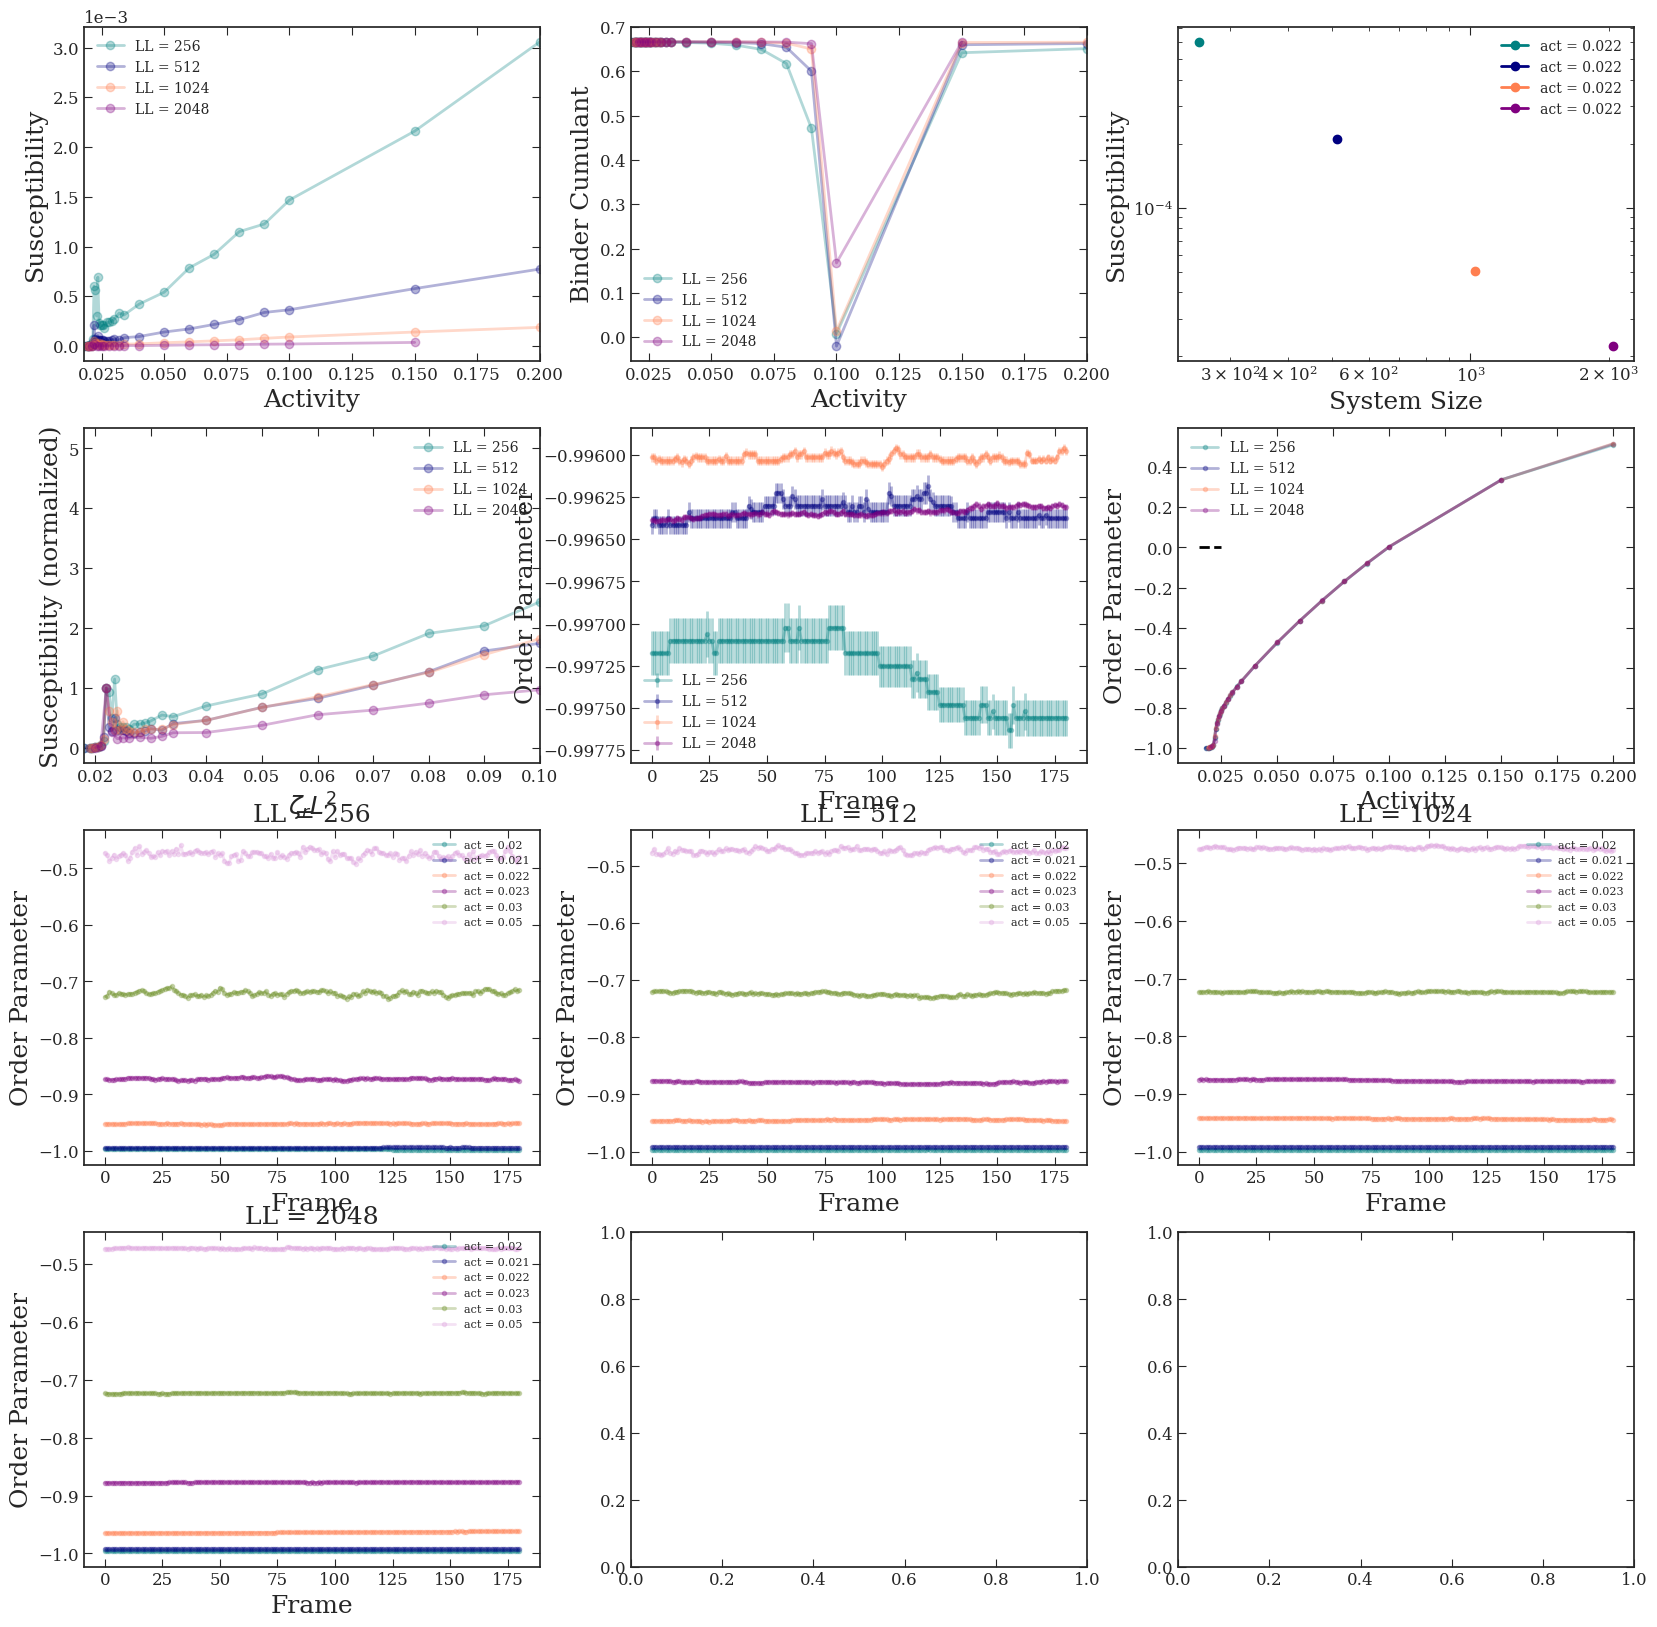

In [5]:
Nscale = False
shift = False
center = 0




act = 0.022
ada = AnalyseDefectsAll(system_size_list)
act_list, av_def = ada.get_av_defects(LX = 1024)
av_def_max = av_def[act_list.index(act)][0]

def order_param_func(def_arr, av_defects, LX, shift = False):
    adaa = AnalyseDefectsAll(system_size_list)
    act = 0.022
    act_list, av_def = adaa.get_av_defects(LX = LX)
    av_def_max = av_def[act_list.index(act)][0]
    if shift:

        order_param = def_arr - av_def_max * LX ** 2 #av_defects[:,0][None, :, None]
    else:
        order_param = def_arr 

    A = np.pi * 1.25 ** 2
    scaling = 1
    rho_max = 0.02
    Nmax = rho_max * LX ** 2
    
 #   order_param = (scaling * 2  * A * def_arr - LX ** 2) / (LX ** 2)
   # def_arr_n = (2 * def_arr * LX ** 2 - Nmax) / (Nmax)
    order_param = (scaling * 2  * def_arr - rho_max * LX ** 2) / (rho_max * LX ** 2 )

    #order_param /= av_defects[:,0][None, :, None]
  #  order_param *= LX
 #   order_param /= LX ** 2
  #
   # order_param /= av_defects[:,0][None, :, None]
    return order_param
        
fig, ax = analyse_sus_binder(Nscale = Nscale, system_size_list = system_size_list[:], center = center,\
                              order_param_func = order_param_func, shift = shift, act_to_plot = 0.020)

ax[0].set_xlim(0.018, 0.2)
ax[1].set_xlim(.018,.2)
#ax[1].set_ylim(0, 1)
#ax[1].vlines(act, 0, 1, linestyle = '--', color = 'k')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[3].set_xlim(0.018, 0.1)
#ax[5].set_xlim(0.019, 0.025)
#ax[5].set_ylim(-30, 2)

ax[5].hlines(0, 0.015, 0.025, linestyle = '--', color = 'k')

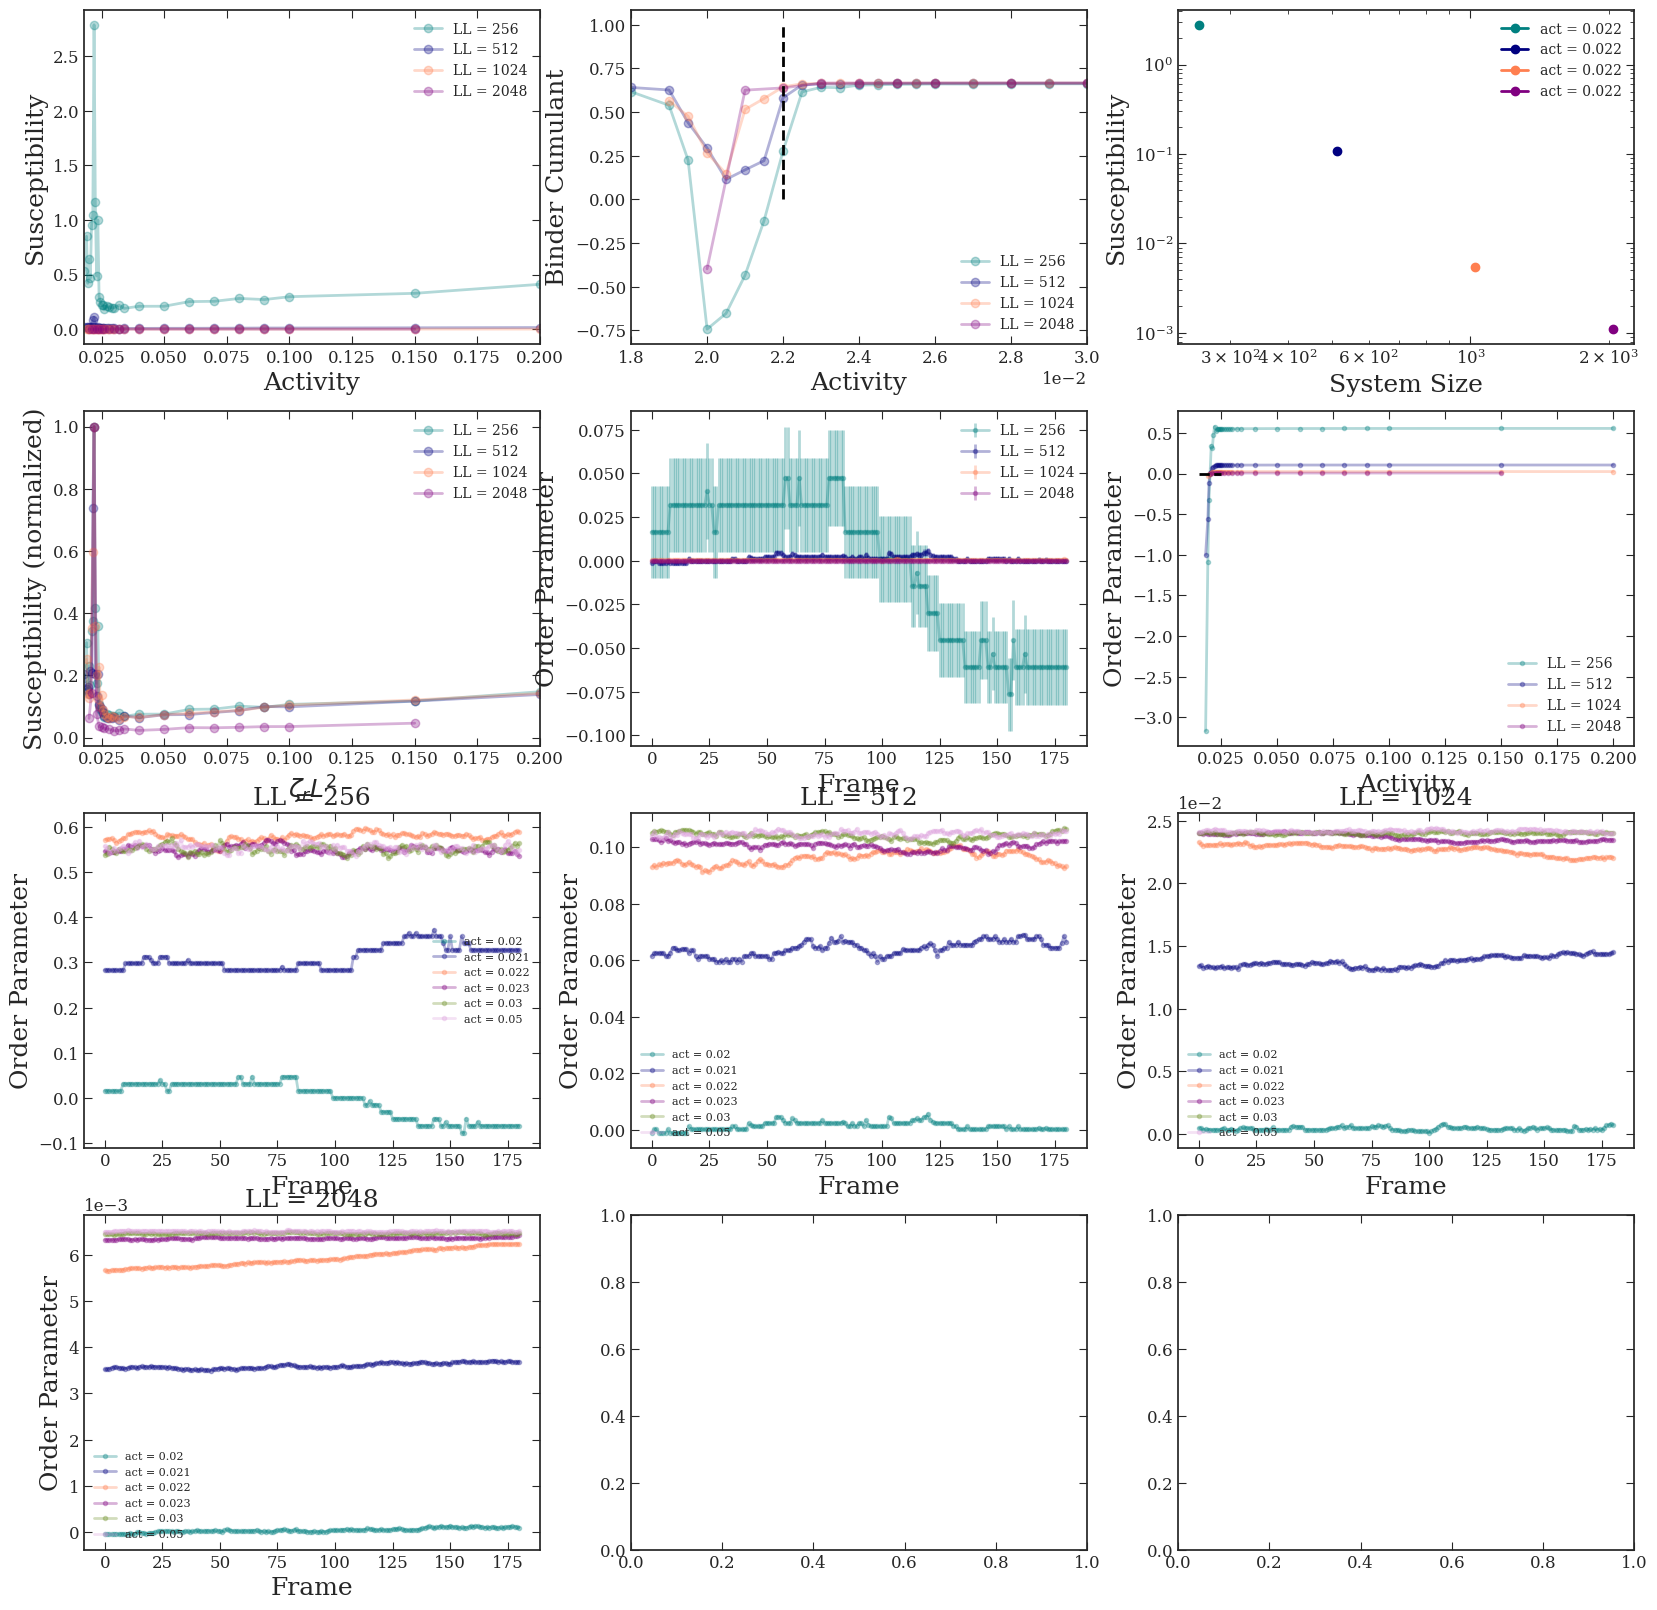

In [9]:
Nscale = True
shift = True
center = 0

act = 0.022
ada = AnalyseDefectsAll(system_size_list)
act_list, av_def = ada.get_av_defects(LX = 1024)
av_def_max = av_def[act_list.index(act)][0]

def order_param_func(def_arr, av_defects, LX, shift = False):
    adaa = AnalyseDefectsAll(system_size_list)
    act = 0.020
    act_list, av_def = adaa.get_av_defects(LX = LX)
    av_def_max = av_def[act_list.index(act)][0]
    if shift:

        order_param = def_arr - av_def_max * LX ** 2 #av_defects[:,0][None, :, None]
    else:
        order_param = def_arr 

    order_param /= av_defects[:,0][None, :, None]
    return order_param
        
fig, ax = analyse_sus_binder(Nscale = Nscale, system_size_list = system_size_list[:], center = center,\
                              order_param_func = order_param_func, shift = shift, act_to_plot = 0.020)

ax[0].set_xlim(0.018, 0.2)
ax[1].set_xlim(.018,.03)
ax[1].vlines(act, 0, 1, linestyle = '--', color = 'k')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[3].set_xlim(0.018, 0.2)
#ax[5].set_xlim(0.019, 0.025)
#ax[5].set_ylim(-30, 2)

ax[5].hlines(0, 0.015, 0.025, linestyle = '--', color = 'k')

In [ ]:
fig.set()

AttributeError: Figure.set() got an unexpected keyword argument 'xlabel'

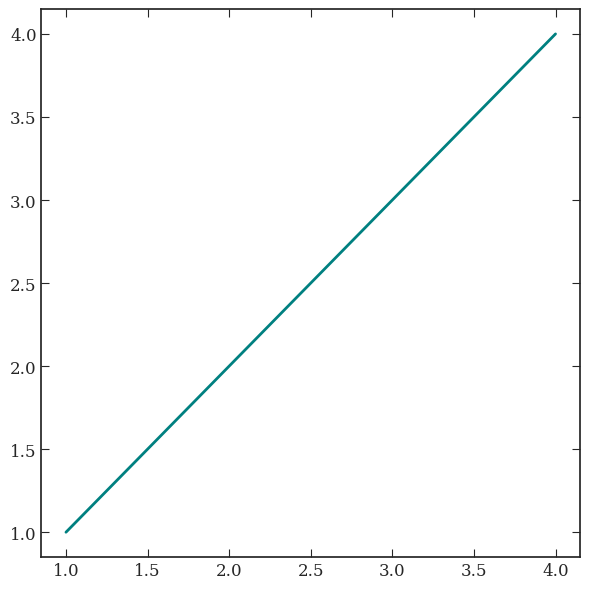

In [16]:
from matplotlib import tight_layout
from matplotlib.pyplot import suptitle


fig, ax = plt.subplots(figsize = (6, 6))

ax.plot([1,2,3,4], [1,2,3,4], label = 'a')

fig.set(tight_layout = True, xlabel='x')

In [70]:
act_list, av_def = ada.get_av_defects(LX = 1024)

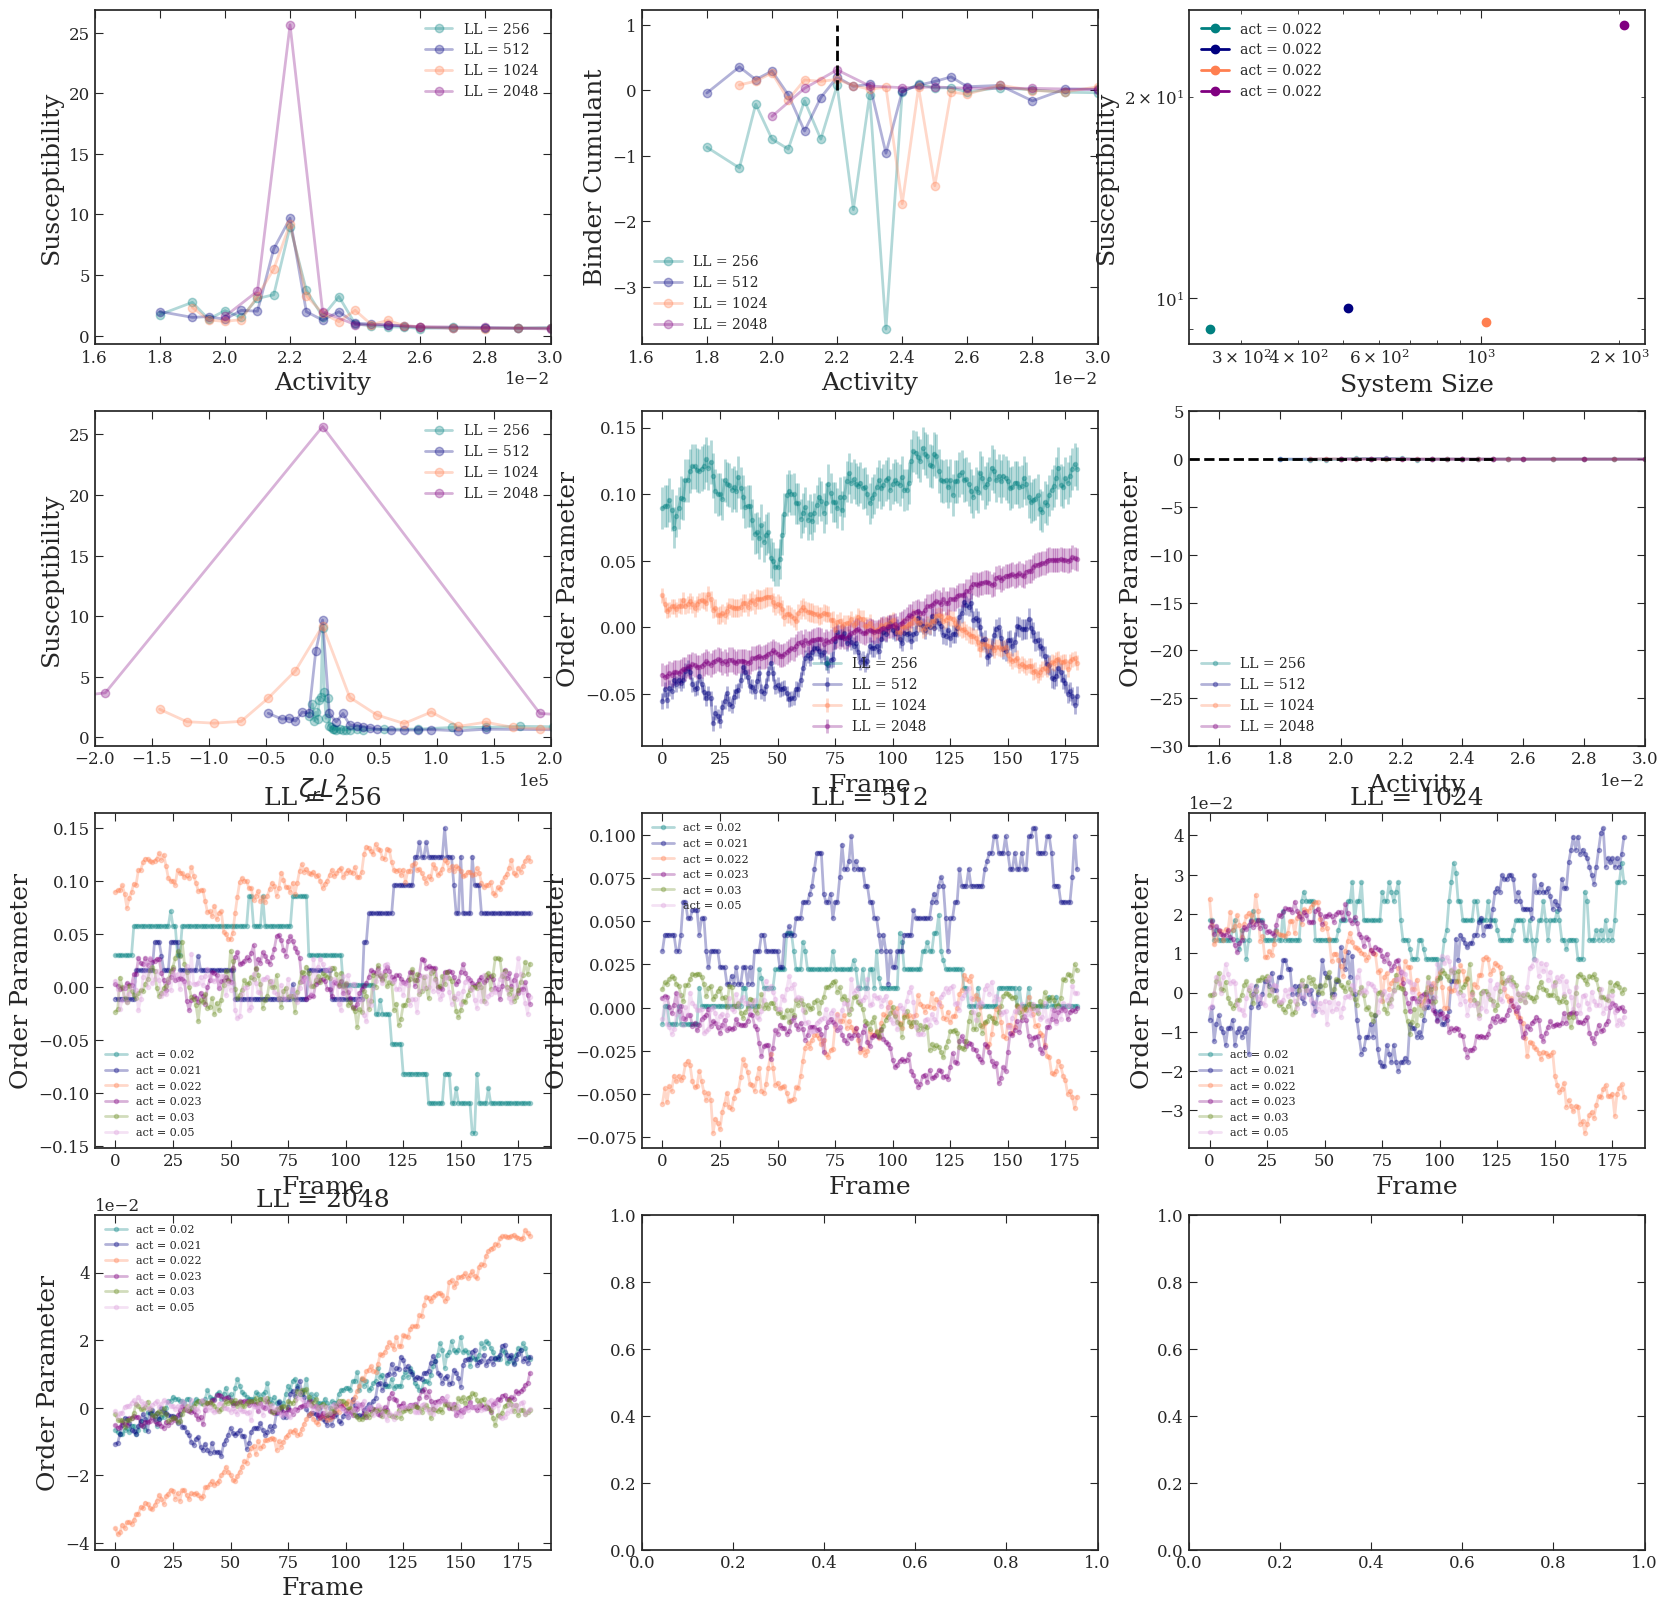

In [86]:
Nscale = True
shift = True
center = 0

act = 0.022
ada = AnalyseDefectsAll(system_size_list)
act_list, av_def = ada.get_av_defects(LX = 1024)
av_def_max = av_def[act_list.index(act)][0]

def order_param_func(def_arr, av_defects, LX, shift = False):
    adaa = AnalyseDefectsAll(system_size_list)
    act = 0.022
    act_list, av_def = adaa.get_av_defects(LX = LX)
    av_def_max = av_def[act_list.index(act)][0]
    if shift:

        order_param = def_arr - av_defects[:,0][None, :, None] # av_def_max * LX ** 2 #av_defects[:,0][None, :, None]
    else:
        order_param = def_arr 

    order_param /= av_defects[:,0][None, :, None]
  #  order_param *= LX
   # order_param /= LX 
  #  order_param /= av_defects[:,0][None, :, None]
 #   order_param = (def_arr - av_def_max * LX ** 2) / av_defects[:,0][None, :, None] # / (av_def_max * LX ** 2)
    return order_param
        
fig, ax = analyse_sus_binder(Nscale = Nscale, system_size_list = system_size_list[:], center = center,\
                              order_param_func = order_param_func, shift = shift, act_to_plot = 0.022)

ax[0].set_xlim(0.016, 0.03)
ax[1].set_xlim(.016,.03)
ax[1].vlines(act, 0, 1, linestyle = '--', color = 'k')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[3].set_xlim(-.2e6,.2e6)
ax[5].set_xlim(0.015, 0.03)
ax[5].set_ylim(-30, 5)

ax[5].hlines(0, 0.015, 0.025, linestyle = '--', color = 'k')

In [202]:
L = 1024
N = 0
#ada = AnalyseDefectsAll(system_size_list)
#bind, sus = ada.get_binder_susceptibility(LX = L)

output_path = f'data\\nematic_analysis{L}_LL0.05'
ad = AnalyseDefects(gen_analysis_dict(L, 'all'), output_path = output_path)
bind, sus = ad.get_binder_susceptibility(Ndataset = N)
def_arr = ad.get_arrays_full(Ndataset = N)[0]
def_arr_av, _, _, _, _, _, av_def = ad.get_arrays_av(Ndataset = N)
act_list = ad.act_list[N]
conv_list = ad.conv_list[N]
#conv_list = [1100] * len(act_list)

In [ ]:
from scipy.stats import moment, kstat

In [ ]:
def generate_moments(order_param, LX, conv_list):

    moments = np.nan * np.zeros((4, order_param.shape[1]))

    for i in range(order_param.shape[1]):

        cum1 = kstat(order_param[conv_list[i]:, i, :], n = 1, axis = None, nan_policy = 'omit')
        cum2 = kstat(order_param[conv_list[i]:, i, :], n = 2, axis = None, nan_policy = 'omit')
        cum3 = kstat(order_param[conv_list[i]:, i, :], n = 3, axis = None, nan_policy = 'omit')
        cum4 = kstat(order_param[conv_list[i]:, i, :], n = 4, axis = None, nan_policy = 'omit')

        moments[0, i] = cum1 * LX
        moments[1, i] = cum2 * LX + cum1 ** 2 * LX ** 2
        moments[2, i] = cum3 * LX + 3 * cum1 * cum2 * LX ** 2 + cum1 ** 3 * LX ** 3
        moments[3, i] = cum4 * LX + (3 * cum2 ** 2 + 4 * cum1 * cum3) * LX ** 2 + 6 * cum1 ** 2 * cum2 * LX ** 3 + cum1 ** 4 * LX ** 4

    return moments

In [ ]:

binder2 = np.zeros_like(bind)
binder0 = np.zeros_like(bind)
center = 0
conv_list = [1100] * len(act_list)

moms = generate_moments((def_arr / av_def[:,0][None, :, None]), L, conv_list)

for i, act in enumerate(act_list):

        binder0[i] = 1 - moms[3, i] / (3 * moms[1, i] ** 2)

        mom4 = moment(def_arr[conv_list[i]:, i, :], moment = 4, axis = None, center = center, nan_policy = 'omit')
        mom2 = moment(def_arr[conv_list[i]:, i, :], moment = 2, axis = None, center = center, nan_policy = 'omit')
        binder2[i] = 1 - mom4 / (3 * mom2 ** 2)
        print(act, binder2[i], bind[i])
fig, ax = plt.subplots()
ax.plot(act_list, binder2, 'x', label = 'moment')
ax.plot(act_list, bind, 'o', alpha=.4, label = 'binder')
ax.plot(act_list, binder0, 'x', label = 'mom0')
ax.legend()


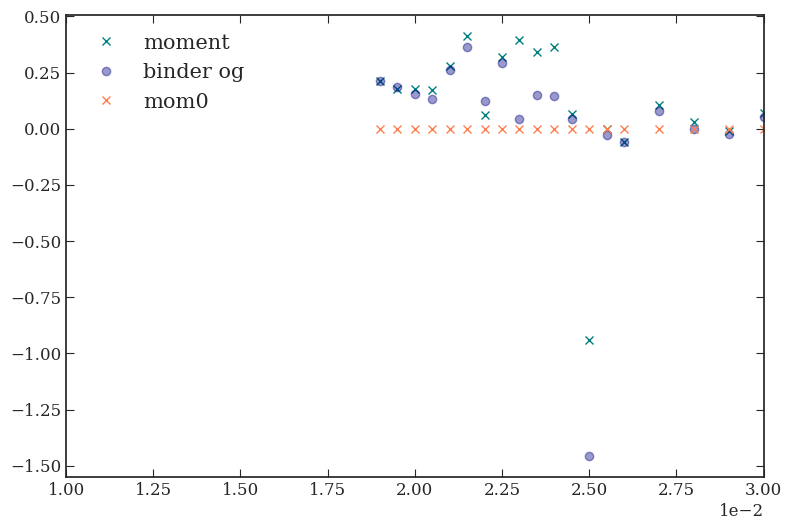

In [203]:

binder2 = np.zeros_like(bind)
binder0 = np.zeros_like(bind)
center = 0
#conv_list = [1100] * len(act_list)

conv_list = ad.conv_list[N]
#conv_list[-1] = 350
#conv_list[-2] = 1100
#conv_list[-3] = 1100
#conv_list[-4] = 0
#conv_list = [1000] * l
# en(act_list)
#conv_list = [1100] * len(act_list)


A = np.pi * 1.25 ** 2
scaling = 1
rho_max = 0.01
##order_param = (2  * A * def_arr - L ** 2) / L ** 2
order_param = (def_arr  - av_def[:,0][None, :, None]) / L**2
order_param = (def_arr  - def_arr_av[:, :, None]) / L**2

#moms = generate_moments((def_arr / av_def[:,0][None, :, None]), L, conv_list)
moms = generate_moments(order_param, L, conv_list)

for i, act in enumerate(act_list):

        binder0[i] = 1 - moms[3, i] / (3 * moms[1, i] ** 2)

        mom4 = moment(order_param[conv_list[i]:, i, :], moment = 4, axis = None, center = center, nan_policy = 'omit')
        mom2 = moment(order_param[conv_list[i]:, i, :], moment = 2, axis = None, center = center, nan_policy = 'omit')
        binder2[i] = 1 - mom4 / (3 * mom2 ** 2)
       
fig, ax = plt.subplots()
ax.plot(act_list, binder2, 'x', label = 'moment')
ax.plot(act_list, bind, 'o', alpha=.4, label = 'binder og')
ax.plot(act_list, binder0, 'x', label = 'mom0')
ax.set_xlim(0.01,0.03)
ax.legend()


In [52]:
A = np.pi * 1.25 ** 2
scaling = 1
rho_max = 0.01
#order_param = (2  * A * def_arr - LX ** 2) / LX ** 2
#Nmax = rho_max * LL ** 2
#def_arr_a = (scaling * 2  * A * def_arr * LL ** 2 - LL ** 2) / (LL ** 2)
#def_arr_n = (2 * def_arr * LL ** 2 - Nmax) / (Nmax)
#def_arr_rho = (scaling * 2  * def_arr - rho_max) / (rho_max)

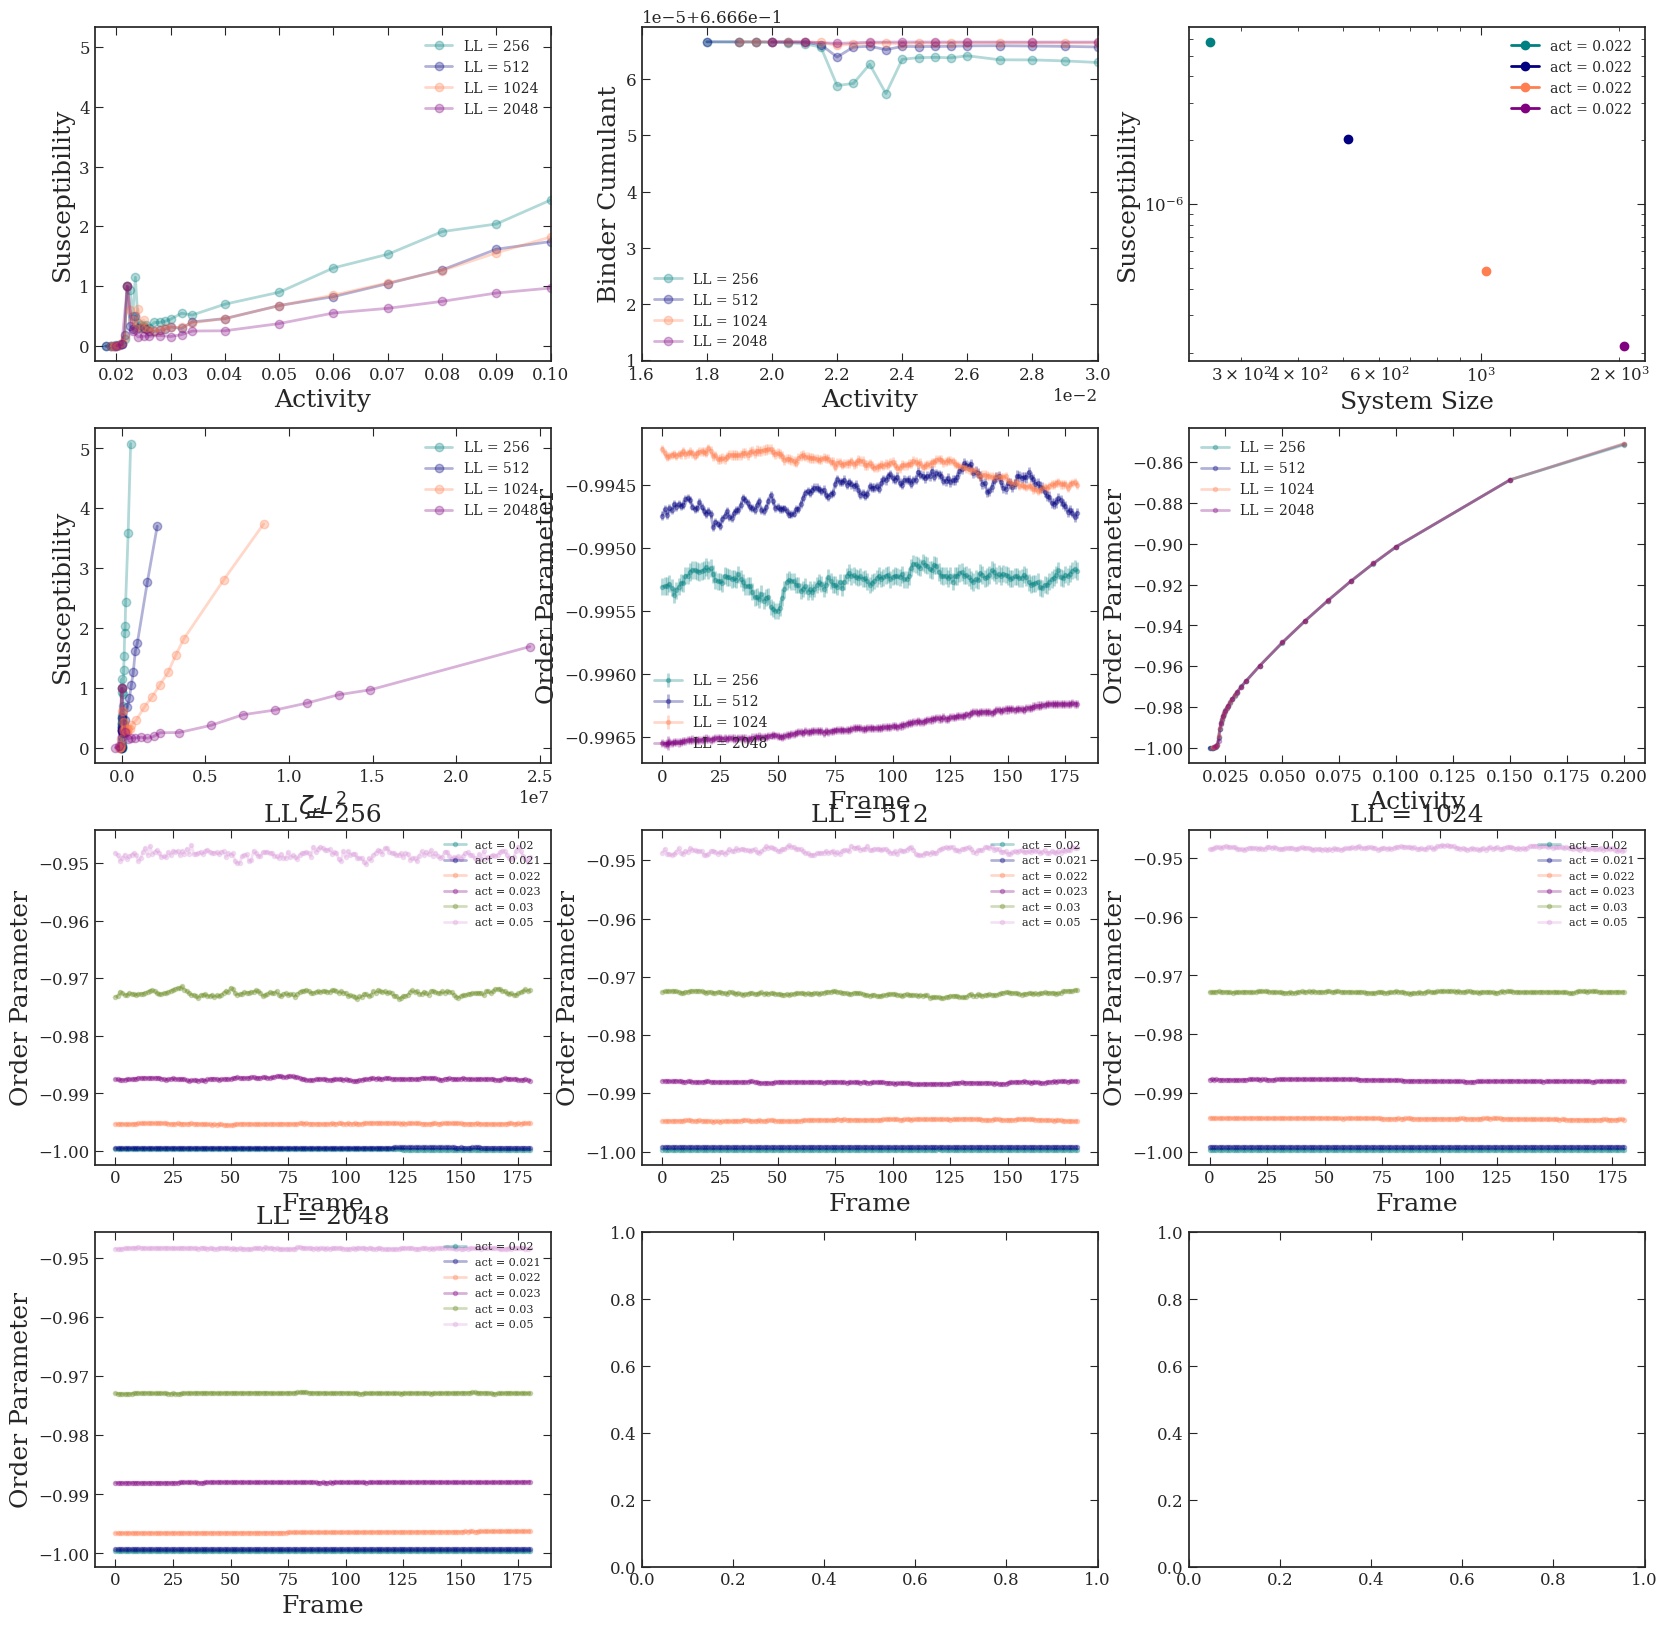

In [53]:
Nscale = False
shift = False
Npower = 1

def order_param_func(def_arr, av_defects, LX, shift = False):
    if shift:
        order_param = def_arr - av_defects[:,0][None, :, None]
    else:
        order_param = def_arr 

    order_param /= av_defects[:,0][None, :, None]
   # order_param *= LX
   # order_param = (2  * A * def_arr - LX ** 2) / LX ** 2
    return order_param
        
fig, ax = analyse_sus_binder(Nscale = Nscale, system_size_list = system_size_list, \
                            order_param_func = order_param_func, Npower = Npower, shift = shift, normalize_sus = True)

ax[0].set_xlim(0.016, 0.1)
ax[1].set_xlim(0.016, 0.03)
ax[2].set_xscale('log')
ax[2].set_yscale('log')